# Analyze data

In [14]:
import json
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import *
import plotly.express as px

In [16]:
# load data
df = pq.read_table('cleaned.parquet').to_pandas()

with open('states.json', 'r') as f:
    locations = json.load(f)

# add PB and relative difference with PB
df['PB'] = df.groupby(['name','gender','agegroup']).time.transform(min).values
df['rel_diff'] = (df.time-df.PB)/df.PB

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1931708 entries, 0 to 1931707
Data columns (total 9 columns):
 #   Column    Dtype   
---  ------    -----   
 0   name      object  
 1   n         int64   
 2   parkrun   category
 3   state     category
 4   gender    category
 5   agegroup  category
 6   time      float64 
 7   PB        float64 
 8   rel_diff  float64 
dtypes: category(4), float64(3), int64(1), object(1)
memory usage: 82.9+ MB


## relative difference per parkrun with overall PB for each individual

In [17]:
tmp1 = df.groupby('parkrun').rel_diff.agg(['median','mean','std'])
tmp1['n'] = df.groupby('parkrun').n.sum()
tmp1

,median,mean,std,n
parkrun,,,,
Airlie Beach,0.051807,0.109194,0.178095,18250
Albert Melbourne,0.000000,0.065121,0.149408,116859
Albury Wodonga,0.000000,0.052699,0.150937,49831
Aldinga Beach,0.032927,0.107298,0.192290,11666
Altona Beach,0.001847,0.074755,0.168269,26937
...,...,...,...,...
Yeppoon,0.029830,0.099950,0.183180,10792
Yokine,0.011586,0.080605,0.169815,20980
You Yangs,0.085522,0.159399,0.238793,6843


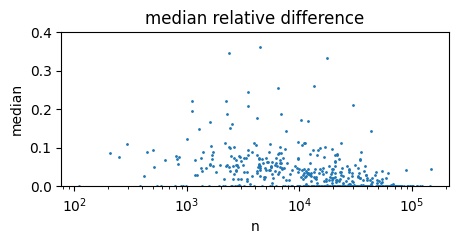

In [18]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp1.plot.scatter(ax = ax, x = 'n', y = 'median', s = 1)
ax.set(xscale = 'log', ylim = [0,0.4], title = 'median relative difference');

Median relative difference by itself is not a good metric since many people compete at only one parkrun, and so their parkrun PB will be set at this course. This means the median relative difference is 0. Let's exclude runners who have only done one parkrun. 

In [19]:
# exclude runners with one parkrun only
freq = df.value_counts(['name','gender','agegroup'])
df = df.set_index(['name','gender','agegroup']).loc[freq[freq>1].index].reset_index()

tmp2 = df.groupby('parkrun').rel_diff.agg(['median','mean','std'])
tmp2['n'] = df.groupby('parkrun').n.sum()

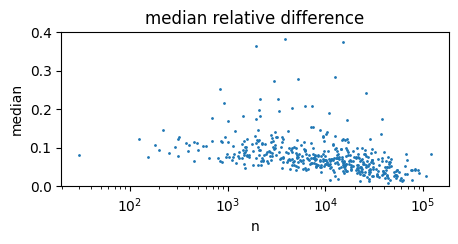

In [20]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp2.plot.scatter(ax = ax, x = 'n', y = 'median', s = 1)
ax.set(xscale = 'log', ylim = [0,0.4], title = 'median relative difference');

Now at least we don't have many parkruns centered at zero. We do however see big differences. Potentially, some of these parkruns are considered as fun runs, and presumably not run all out. Let's assume that for an all out effort, we expect times to be at least within 10% of their PB.

Considering famous parkrunner Aidan Hobbs (holder of 24 courserecords) with PB of 14.34 (30-34) and 14.16 (35-39), this means we expect that he should be able to run under 16.00 (30-34) and 15.40 (35-39) on any course. And only when we have done so, we consider this as an all-out effort that we can use to do compare across parkruns.

Even so, Aidan Hobbs will not go all out at every parkrun he runs. For instance, he can decide to break the course record and once that's in the bag, not push much further. On the other hand, when he has competition, he might go superfast. In Sandgate 18 June 2022, 13 guys went under 15 minutes, so they must have all pushed each other resulting in a supersharp course record by Kieran Perkins (14.14) and a similarly sharp time by Aidan Hobbs (14.16).

In [21]:
df.query('name == "Aidan HOBBS"').sort_values('time').head(10)

,name,gender,agegroup,n,parkrun,state,time,PB,rel_diff
472791,Aidan HOBBS,M,35-39,1,Sandgate,NSW,14.266667,14.266667,0.000000
95382,Aidan HOBBS,M,30-34,2,Sandgate,NSW,14.566667,14.566667,0.000000
95372,Aidan HOBBS,M,30-34,4,Mitchelton,QLD,14.683333,14.566667,0.008009
472790,Aidan HOBBS,M,35-39,3,Rocks Riverside,QLD,14.700000,14.266667,0.030374
472794,Aidan HOBBS,M,35-39,4,Woy Woy,NSW,14.750000,14.266667,0.033879
95390,Aidan HOBBS,M,30-34,1,Wynnum,QLD,14.783333,14.566667,0.014874
472788,Aidan HOBBS,M,35-39,1,Aplins Weir,QLD,14.850000,14.266667,0.040888
95380,Aidan HOBBS,M,30-34,20,Rocks Riverside,QLD,14.933333,14.566667,0.025172
95368,Aidan HOBBS,M,30-34,6,Kedron,QLD,15.000000,14.566667,0.029748
95383,Aidan HOBBS,M,30-34,7,South Bank,QLD,15.083333,14.566667,0.035469


In [22]:
df2 = df.query('rel_diff <= 0.1')

tmp3 = df2.groupby('parkrun').rel_diff.agg(['median','mean','std'])
tmp3['n'] = df2.groupby('parkrun').n.sum()

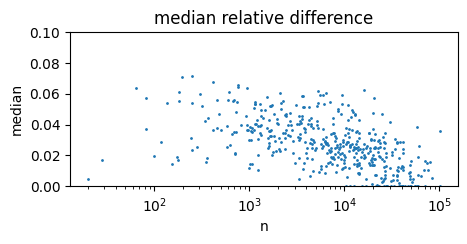

In [23]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp3.plot.scatter(ax = ax, x = 'n', y = 'median', s = 1)
ax.set(xscale = 'log', ylim = [0,0.1], title = 'median relative difference');

This gives a decent spread betweeen parkruns, and no real outliers (which we have of course selected for by only including times within 10% of ones PB). A median of zero means that more than half of the included runners have set their parkrun PB at this particular parkrun. Since there are many parkruns with median 0, let's consider the mean relative difference from a PB next.

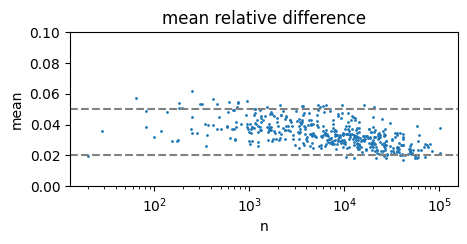

In [24]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp3.plot.scatter(ax = ax, x = 'n', y = 'mean', s = 1)
ax.set(xscale = 'log', ylim = [0,0.1], title = 'mean relative difference');
[ax.axhline(val, ls = '--', c = 'gray') for val in [0.02, 0.05]];

This tightens the distribution of parkruns further, and does allow to make some distinction between parkruns. The fastest ones seem to have an average relative difference of just under 2%, meaning that on average, runners set a time 2% off their PB. 

Note the trend towards lower mean relative difference at higher attendance. It could be that parkruns with high attendance in urban areas are people's "main run" where do they really well, and where their PB approaches their max effort, whilst in other parkuns they may have tried only a few times, and not achieved a comparable 'max-effort' PB for whatever reason (not well rested, more difficult conditions, 'just for fun' mindset, etc.)

To test this hypothesis we can remove some of the dependence of the mean relative difference on the number of runners in an event, we only include races where a parkrunner has participated at least twice. We may want to revisit the less than 0.1 mean relative difference, because these factors are likely related too.

We will also ignore parkruns with less than 100 eligible individuals since these results are noisy and depend on a select few runners.

In [25]:
df3 = df.query('n > 2 and rel_diff <= 0.1')

# recheck whether parkrunners have competed in 2 or more events with above criteria on n and rel_diff
freq = df3.value_counts(['name','gender','agegroup'])
df3 = df3.set_index(['name','gender','agegroup']).loc[freq[freq>1].index].reset_index()

df3.PB = df3.groupby(['name','gender','agegroup']).time.transform(min).values
df3.rel_diff = (df3.time-df3.PB)/df3.PB

tmp4 = df3.groupby(['parkrun']).rel_diff.agg(['median','mean','std'])
tmp4['n'] = df3.groupby('parkrun').n.sum()
tmp4['state'] = tmp4.index.map(locations)
tmp4 = tmp4.query('n > 100')

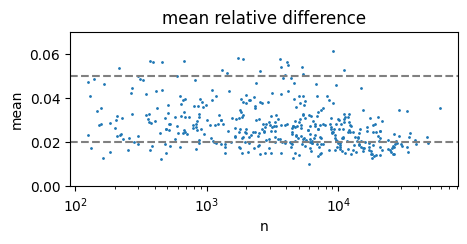

In [26]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp4.plot.scatter(ax = ax, x = 'n', y = 'mean', s = 1)
ax.set(xscale = 'log', ylim = [0,0.07], title = 'mean relative difference');
[ax.axhline(val, ls = '--', c = 'gray') for val in [0.02, 0.05]];

Now the mean relative difference has decreased even further. We are also starting to see patterns emerge. Let's sort the top 50 parkruns with smallest mean relative difference

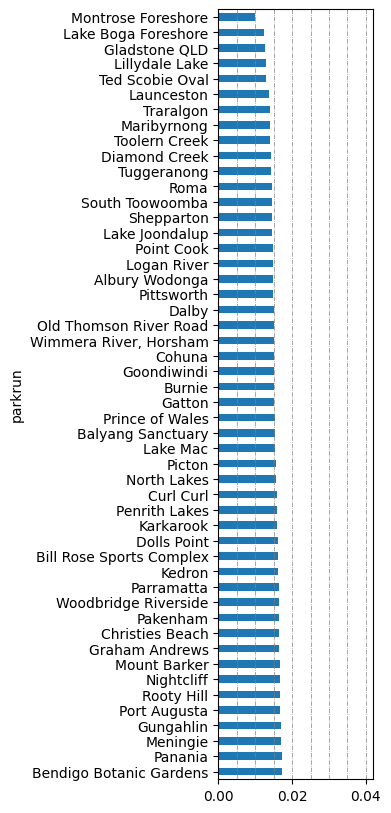

In [27]:
fig, ax = plt.subplots(figsize = (2,10))
tmp4['mean'].sort_values()[:50][::-1].plot(kind = 'barh')
[ax.axvline(x, ls = '-.', lw = 0.5, c = 'gray') for x in np.arange(0.005, 0.04, 0.005)];

## Slowest parkrun
Finally, to understand the slowest parkruns, we remove the constraint that all course PBs need to be within 10% of the parkrun PB or that people will have had to compete at least twice in a parkrun. The reasoning to exclude this data is if too many runners come to this parkrun for leisure, their recorded PB at this parkrun is meaningless. However, all-out efforts on the most difficult parkruns may easily be 10% slower than all-out efforts on flat, asphalt courses. Similarly, their precise PB at such hard courses is less important, just the fact that it is a hard course resulting in times 10% or more away from their PBs is enough signal.

In [28]:
df4 = df

# check whether parkrunners have competed in 2 or more events
freq = df4.value_counts(['name','gender','agegroup'])
df4 = df4.set_index(['name','gender','agegroup']).loc[freq[freq>1].index].reset_index()

df4.PB = df4.groupby(['name','gender','agegroup']).time.transform(min).values
df4.rel_diff = (df4.time-df4.PB)/df4.PB

tmp5 = df4.groupby(['parkrun']).rel_diff.agg(['median','mean','std'])
tmp5['n'] = df4.groupby('parkrun').n.sum()
tmp5['state'] = tmp5.index.map(locations)
tmp5 = tmp5.query('n > 100')

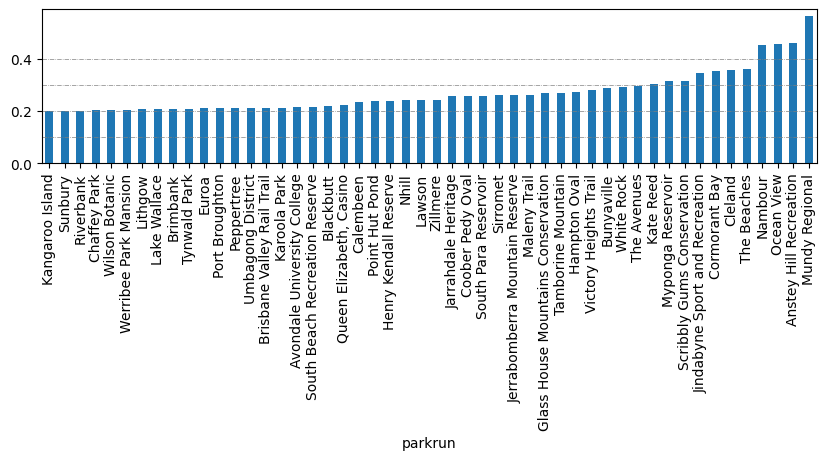

In [29]:
fig, ax = plt.subplots(figsize = (10,2))
tmp5['mean'].sort_values()[-50:].plot(kind = 'bar')
[ax.axhline(x, ls = '-.', lw = 0.5, c = 'gray') for x in np.arange(0.1, 0.5, 0.1)];

This looks good. Upon checking the courses of the slowest four parkruns we note:
- Nambour (near Sunshine Coast): 100% on trails with and a creek crossing
- Ocean View (near Brisbane): Mainly grass, with a dirt track component (8 180 degree turns)
- Anstey Hill Recreation (Adelaide): On and around hills
- Mundy Regional (Perth): all trail with an elevation of approx 215 metres

# Discussion
The main drawback of this approach is that hilly parkruns near a flat parkrun will have a large relative difference. In the extreme case here a town hosts two parkruns, most datapoints will have come from runners competing in both events, and the relative difference can be very large. Some examples:
- Launceston (TAS): Launceston (0.10) vs Kate Reed (0.30)
- Perth (WA): Lake Joondalup (0.08) vs Mundy Regional (0.56)
- Newcastle (NSW): Newy (0.09) vs The Beaches (0.36)

We can probably partially correct for this by pushing the number of unique parkruns participants will have had to set PBs in up from at least 2 to higher. This will add another parameter that we can tune, leaving us with 5:
- minimum number of runners in a parkrun
- minimum number of course PBs
- minimum number of attempts per course
- maximum difference between course PB and overall PB

Then, we haven't even considered scenarios where using median might be more meaningful than the mean.

For all parameter choices, the exact ranking of the top 10 fastest or bottom 10 slowest parkrun will be different. Even if we were to somehow average out effects, still, we are only considering overall effects, not which parkrun may have the fastest times for runners within your age, location, gender and times bracket. 

The most meaningful would be to compare PBs between parkruns within a region that you are willing to travel for. Let's simulate that by making a comparison across states. Not that anyone would be willing to travel 8hours from Sydney to Broken Hill for a meager parkrun, but you get the gist.

In notebook 05b_visualize this is worked out in a widget. It gives a good indication of the fast and slow parkruns per state. By closely inspecting ACT and NT, we can find some drawbacks:
- There are only three parkruns in NT, and comparison among those works but _parkruns_ can't be higher than 3
- Jerrabomberra mountain reserve parkrun takes place just across the ACT / NSW border in NSW, but it is very close to the Canberra city limits. Preferably this parkrun is included in ACT. It was initially even included in the wrong state (VIC) since the name is somehow associated with a geographic location in Victoria according to GeoPy.
- Generically named parkruns like GreenWay and Campbelltown were assigned the wrong state. Instead of attempting to deduce the state from the parkrun name by searching the location in GeoPy, we should extract an address through webscraping where it is _stated_ correctly.